MPC for LTI systems and quadratic cost, with piecewise constant reference tracking and constraint relaxation if infeasibility occurs due to reference changes.

In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
import control as ct # control systems library
import cvxpy as cp
import scipy as sp
from collections import namedtuple
import time as tt
import warnings
warnings.filterwarnings('ignore')
import rpc_diism.mpc as mpc

Relaxation triggered for empty terminal set at t=10.0
Relaxation triggered for infeasibility at t=15.0


'Simulation time:'

9.088587999343872

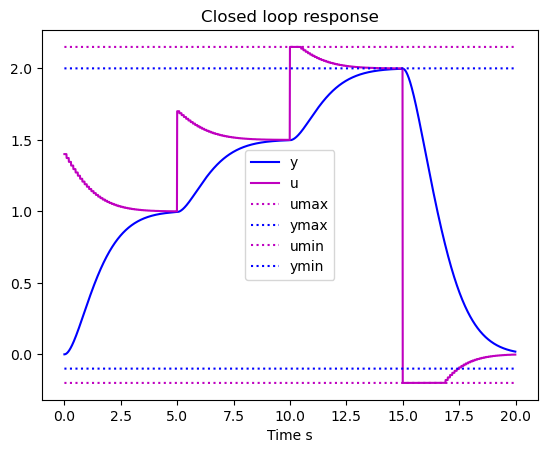

In [2]:
# Continuous-time plant model
A = np.array([[-1, 1],
              [0, -1]])
B = np.array([[0],
              [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

(no,nx) = C.shape

# We need to output both the actual output (for plotting) and the state (for feedback)
Ctot = np.vstack((C, np.eye(nx)))
Dtot = np.vstack((D, np.zeros([nx,1])))
plant_continuous = ct.ss(A,B,Ctot,Dtot, 
                   inputs='u', states=['x[0]','x[1]'], outputs=['y','x[0]','x[1]'])

# This is the step to simulate the continuous time plant (and the closed loop)
simulation_dt = 0.01
# Generate a discrete-time simulator of the plant with the simulation step
plant_simulator = ct.c2d(plant_continuous, simulation_dt, 'zoh')

# Controller sampling time
T = 0.1

# Generate discretized plant model for use with the controller
plant_discrete = ct.c2d(plant_continuous, T, 'zoh')

# MPC controller parameter structure field names
p = namedtuple('parameters', ['A','B','C','N','Q','R','F','f','fa','E','e','ea','Xf','P','Qt','alpharelax','alpharelaxe'])

# Cost weights
p.Q = C.T @ C
p.R = np.array([[1]])

# Horizon length
p.N = 26

# Model
p.A = plant_discrete.A
p.B = plant_discrete.B
p.C = C

# State constraints
ymin = -0.1
ymax = 2.0
p.F = np.block([[C],
                [-C] ])
p.f = np.array([[ymax],
                [-ymin] ])

# This holds the initial f when reference changes
p.fa = p.f

# Input constraints
umin = -0.2
umax = 2.15
p.E = np.array([[1],
                [-1] ])
p.e = np.array([[umax],
                [-umin] ])

# This holds the initial e when reference changes
p.ea = p.e

# Plant state and input dimension
(nx,nu) = p.B.shape

# Terminal set type
p.Xf = 'lqr'

# Start by not relaxing costraints
p.alpharelax = None

# Penalty on state constraint violation when relaxation is triggered
p.alpharelaxe = 100


# Define the MPC controller system object
controller = mpc.mpc_controller_with_relax(p, T, 
                            inputs=['ref','x[0]','x[1]'], outputs='u')

# Create model of controller for simulation with the same integration time
# as the plant
controller_simulator = mpc.sampled_data_controller(controller, simulation_dt)

# Compute closed loop. The closed loop state has nu*p.N+no states (the controller states: optimal seq. plus integrator state)
# plus nx states (the plant simulator states)
closedloop_simulator = ct.interconnect([controller_simulator, plant_simulator], inputs='ref', outputs=['y', 'u'],
                        states = nu*p.N + nx)

# Time vector for simulation
end_time = 20
time = np.arange(0, end_time, simulation_dt)

# Split the time vector in 4, in each interval we have a different reference
time1, time2, time3, time4 = np.split(time, 4)

# Reference vector (piecewise constant)
ref1 = 1*np.ones_like(time1)
ref2 = 1.5*np.ones_like(time2)
ref3 = 2*np.ones_like(time1)
ref4 = 0*np.ones_like(time2)
ref = np.hstack([ref1,ref2,ref3,ref4])

# Initial plant state
initx0 = np.array([0,0])

# The controller state is the optimal input sequence: we initialize it to zero
initu = np.zeros(nu*p.N)

# Closed loop initial state
initx = np.hstack((initu, initx0))

# Simulate
start_t = tt.time()
t, resp = ct.input_output_response(closedloop_simulator, time, ref, initx)
stop_t = tt.time()
display("Simulation time:", stop_t - start_t)

# Plot responses
y, u = resp # extract responses
plt.plot(t, y, 'b-', label='y')
plt.plot(t, u, 'm-', label='u')
plt.plot(t, umax*np.ones_like(t), 'm:', label='umax')
plt.plot(t, ymax*np.ones_like(t), 'b:', label='ymax')
plt.plot(t, umin*np.ones_like(t), 'm:', label='umin')
plt.plot(t, ymin*np.ones_like(t), 'b:', label='ymin')
plt.xlabel("Time s")
plt.title("Closed loop response")
plt.legend();